In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [5]:
data = pd.read_csv('data_DL/dataset.csv')

In [6]:
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [7]:
print('Number of records:\t', data.shape[0])
print('Number of attributes:\t', data.shape[1])

Number of records:	 19906
Number of attributes:	 2


In [8]:
duplicates = data[data.duplicated()]
print('Number of duplicate rows:', duplicates.shape[0])

Number of duplicate rows: 0


In [9]:
missing = data[data.isnull().any(axis=1)]
print('Number of rows with missing value:', duplicates.shape[0])

Number of rows with missing value: 0


In [10]:
image_path = 'data_DL\\images'

missing_images = []

for img_name in data['ID']:
    img_file = os.path.join(image_path, img_name)
    if not os.path.exists(img_file):
        missing_images.append(img_name)

print('Number of missing images (jpg):', len(missing_images))

Number of missing images (jpg): 0


In [11]:
print(data['Class'].value_counts())

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


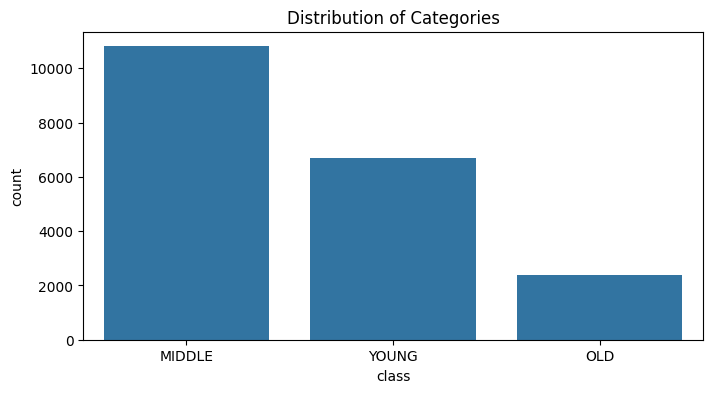

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=data)
plt.xlabel('class') 
plt.title('Distribution of Categories')
plt.show()

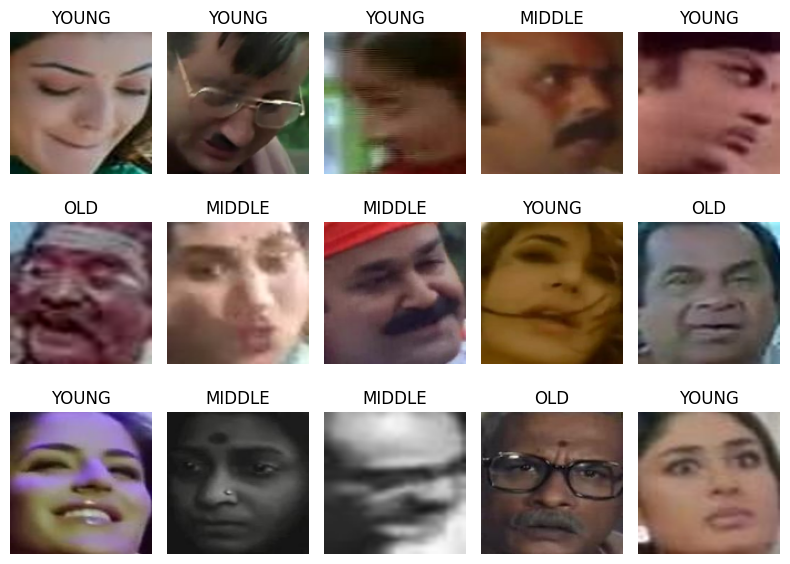

In [13]:
image_dir = 'data_DL\\images'
sample_data = data.sample(15)

fig, axes = plt.subplots(3, 5, figsize=(8, 6))
axes = axes.flatten()

for i, (index, row) in enumerate(sample_data.iterrows()):
    img_id = row['ID']
    category = row['Class']

    img_path = os.path.join(image_dir, img_id)
    img = Image.open(img_path)

    img = img.resize((128, 128))

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
data['image_path'] = data['ID'].apply(lambda x: os.path.join(image_dir, x))

In [15]:
def image_to_numpy(img_path):
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    
    img_resized = tf.image.resize(img_array, (128, 128))
    
    return img_resized.numpy()

In [16]:
data['image_data'] = data['image_path'].apply(lambda x: image_to_numpy(x))
data.head()

,ID,Class,image_path,image_data
0,377.jpg,MIDDLE,data_DL\images\377.jpg,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51...."
1,17814.jpg,YOUNG,data_DL\images\17814.jpg,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47...."
2,21283.jpg,MIDDLE,data_DL\images\21283.jpg,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3..."
3,16496.jpg,YOUNG,data_DL\images\16496.jpg,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21...."
4,4487.jpg,MIDDLE,data_DL\images\4487.jpg,"[[[31.398438, 30.398438, 36.398438], [29.26171..."


In [17]:
data = pd.get_dummies(data, columns=['Class'], prefix='class')
data = data.drop(['ID', 'image_path'], axis=1)

data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']] = data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']].astype(int)

data.head()

,image_data,class_MIDDLE,class_OLD,class_YOUNG
0,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51....",1,0,0
1,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47....",0,0,1
2,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3...",1,0,0
3,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21....",0,0,1
4,"[[[31.398438, 30.398438, 36.398438], [29.26171...",1,0,0


In [18]:
X = np.stack(data['image_data'].to_numpy())
y = data[['class_YOUNG', 'class_MIDDLE', 'class_OLD']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [tf.convert_to_tensor(d, dtype=tf.float32) for d in [X_train, X_test, y_train, y_test]]
X_train, X_test, y_train, y_test = datasets

In [19]:
rescale_layer = Rescaling(scale=1.0/255)

X_train_transformed = rescale_layer(X_train)
X_test_transformed = rescale_layer(X_test)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_transformed, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_transformed, y_test))

In [21]:
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Train image batch shape:\t', images.shape)
    print('Train label batch shape:\t', labels.shape, '\n')

for images, labels in test_dataset.take(1):
    print('Test image batch shape: \t', images.shape)
    print('Test label batch shape: \t', labels.shape)

Train image batch shape:	 (32, 128, 128, 3)
Train label batch shape:	 (32, 3) 

Test image batch shape: 	 (32, 128, 128, 3)
Test label batch shape: 	 (32, 3)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),  # Input shape

    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Fourth Convolutional Block (for better feature extraction)
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    # Global Average Pooling instead of Flatten
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    tf.keras.layers.Dense(128, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output neurons for the classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Slightly lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\nikof\Desktop\Skola2\IAU_B\iau\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


AttributeError: module 'keras.api.optimizers' has no attribute 'adam'

In [38]:
print("Available devices:", tf.config.list_physical_devices())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset
)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs detected: []
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 98s 193ms/step - accuracy: 0.5377 - loss: 0.9897 - val_accuracy: 0.5477 - val_loss: 0.9642
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 109s 218ms/step - accuracy: 0.5394 - loss: 0.9670 - val_accuracy: 0.5477 - val_loss: 0.9560
Epoch 3/20
 46/498 ━━━━━━━━━━━━━━━━━━━━ 1:59 265ms/step - accuracy: 0.5373 - loss: 0.9550

KeyboardInterrupt: 

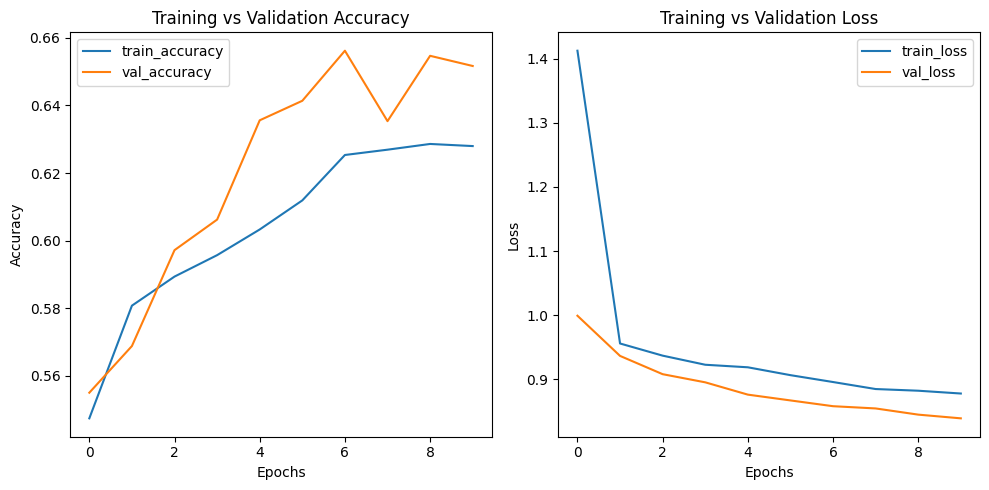

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()